In [83]:
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch, find_peaks
import matplotlib.pyplot as plt

In [18]:
data = [signal.rstrip('\n') for signal in open('DataN.txt')]
signals = []
for signal in data:
    signals.append(float(signal))
    
time_axis = np.linspace(0,4*len(signals), len(signals));

In [3]:
def notch_filter(noisy_signals, sampling_rate, dc_component: int=50, quality_factor: int = 30):
    
    b, a = iirnotch(dc_component, quality_factor, sampling_rate)
    noise_free_signals = lfilter(b, a, noisy_signals)
    
    return noise_free_signals

In [238]:
def butter_bandpass_filter(noisy_signals, lowcut: float=0.1, highcut: float= 45.0, sampling_rate, order: int = 5):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    noise_free_signals = lfilter(b, a, noisy_signals)
    return noise_free_signals

In [241]:
def filter_noise(noisy_signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, dc_component):
    
    dc_component_removed = notch_filter(noisy_signals,
                                        sample_rate, dc_component)
    
    noise_free_signals = butter_bandpass_filter(dc_component_removed,
                                                low_cut_frequncy,
                                                high_cut_frequncy,sample_rate)
    return noise_free_signals
    

In [16]:
def derivatise(signals):
    filterd_signals= np.zeros((len(signals)))
    filterd_signals[0:2] = signals[0:2]

    T = 1/256
    for s in range(2,len(signals)-2):
        op = -2*(signals[s-1])
        op -= ((signals[s-2]))
        op += (signals[s+2])
        op += (2*(signals[s+1]))
        op *= (1/(8*T))
        filterd_signals[s] += op
    
    return filterd_signals

In [17]:
def square(differentiated_signals):
    squared_signals = []
    for signal in differentiated_signals:
        squared_signals.append(np.square(signal))
    return squared_signals     

In [69]:
def smoothen(squared_signals, window_size):
    smoothed_signals = np.zeros((len(squared_signals)))
    smoothed_signals[0:window_size] = squared_signals[0:window_size]
    starting_index = window_size-1
    for signal in range(starting_index, len(squared_signals)):
        for index in range(0, window_size):
            smoothed_signals[signal] += (squared_signals[signal-index])
        smoothed_signals[signal] /= window_size
    return smoothed_signals

In [205]:
def set_threshold(signals, N: int=50):
    maximum_signal = max(signals)
    threshold = abs(((1/N))*maximum_signal)  
    return threshold  

In [211]:
def R_indices(signals, threshold, distance: int=150):
    R_waves= find_peaks(signals,height= threshold, distance= distance )
    return R_waves    

In [80]:
def R_peaks(signals, peak_indices):
    R_peaks = []
    for index in peak_indices:
        R_peaks.append(signals[index])          
    return R_peaks

In [242]:
def RR_intervals(signals, RR_indexes):
    RR_intervals = []

    for index in range(0,len(RR_indexes)-1):
        R= RR_indexes[index]
        RR = RR_indexes[index+1]
        RR_intervals.extend(signals[R:RR])
    return RR_intervals

In [243]:
def RR_timestamps(time_axis, RR_indexes):
    
    RR_timestamps = []
    for index in range(0,len(RR_indexes)-1):
        t= RR_indexes[index]
        tt = RR_indexes[index+1]
        RR_timestamps.extend(time_axis[t:tt])
    RR_timestamps.append(time_axis[len(RR_indexes)-1])   
    return RR_timestamps
    

In [346]:
def R_timestamps(time_axis, R_index):
    R_timestamps = []
    for index in R_index:
        R_timestamps.append(time_axis[index])
    return R_timestamps

In [300]:
def electrocardiogram(signals, window_size):
    
    differentiated_signals = derivatise(signals)
    squared_signals = square(differentiated_signals)
    smoothed_signals = smoothen(squared_signals,window_size)
    threshold = set_threshold(smoothed_signals, window_size)
    
    RR_indices = R_indices(smoothed_signals, threshold)
    RR_peaks = R_peaks(smoothed_signals, RR_indices[0])
    
    return RR_peaks, smoothed_signals, RR_indices

# Deliverables

## Signals After Filtering

In [5]:
sample_rate =256
frequency_to_remove = 50
low_cut_frequncy = 0.1
high_cut_frequncy = 45
window_size_5 = 5
window_size_15 = 15
window_size_25 = 25


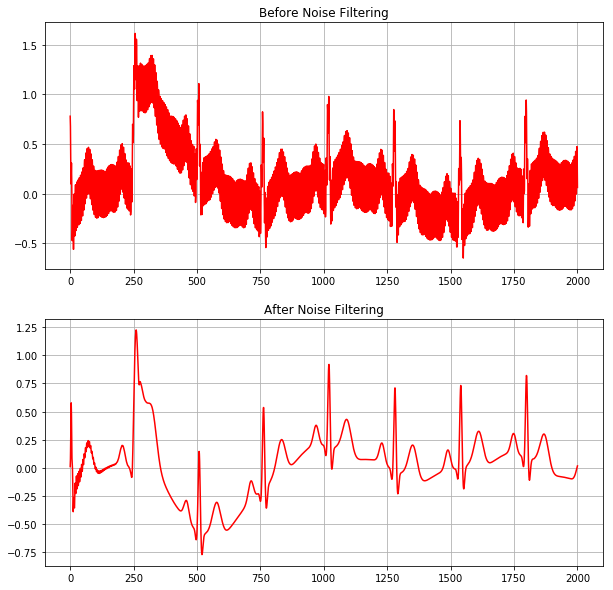

In [247]:
time_axis = np.linspace(0,2000, 2000);

noise_free_signals = filter_noise(signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, frequency_to_remove)

figure, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].grid()
ax[0].plot(time_axis, signals[0:2000], color='red')
ax[0].title.set_text('Before Noise Filtering')

ax[1].plot(time_axis, noise_free_signals[0:2000], color='red')
ax[1].grid()
ax[1].title.set_text('After Noise Filtering')

## ECG Signals With Different WIndow Sizes

In [301]:
filtered_signals = filter_noise(signals, low_cut_frequncy,
                 high_cut_frequncy, sample_rate, frequency_to_remove)

R5_peaks, smooth_filtered_5,_ = electrocardiogram(filtered_signals,5)
R15_peaks, smooth_filtered_15,_= electrocardiogram(filtered_signals,15)
R25_peaks, smooth_filtered_25, R25_indices= electrocardiogram(filtered_signals,25)

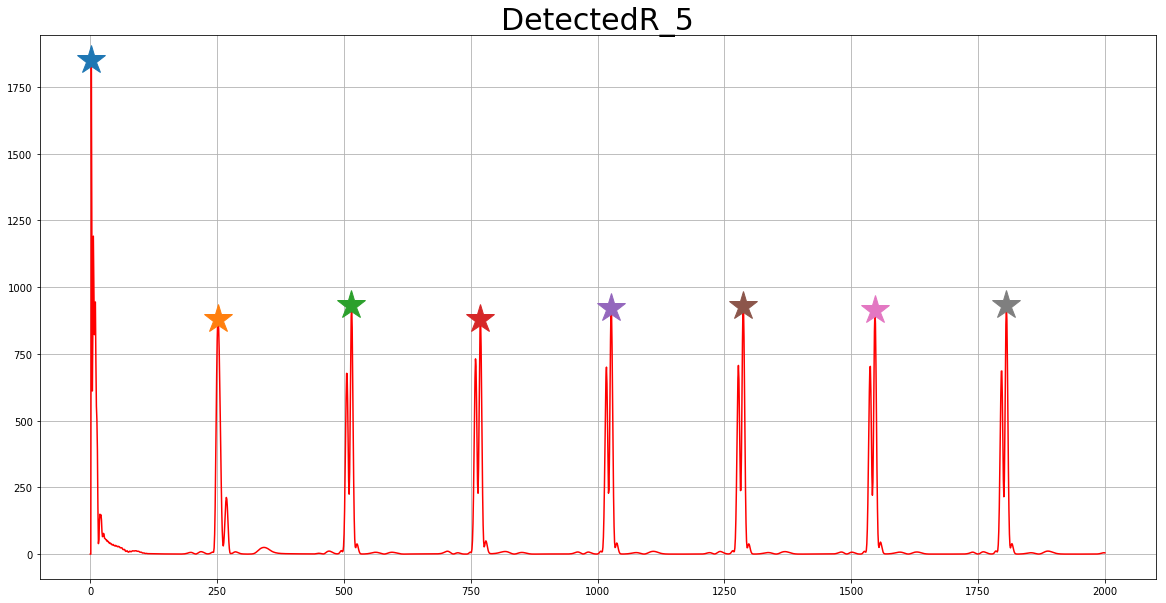

In [296]:
RR_figure, RR_ax = plt.subplots(figsize=(20, 10))
time = time_axis[0:2000]
smooth_filtered_5= smooth_filtered_5[0:2000]

RR_ax.plot(time,smooth_filtered_5, color='red')
RR_ax.set_title('DetectedR_5', fontsize= 30)
RR_ax.grid()
for i, v in enumerate(smooth_filtered_5):
        if v in R5_peaks:
            plt.plot(time[i]-0.4, v+0.01,  marker='*', markersize=30)

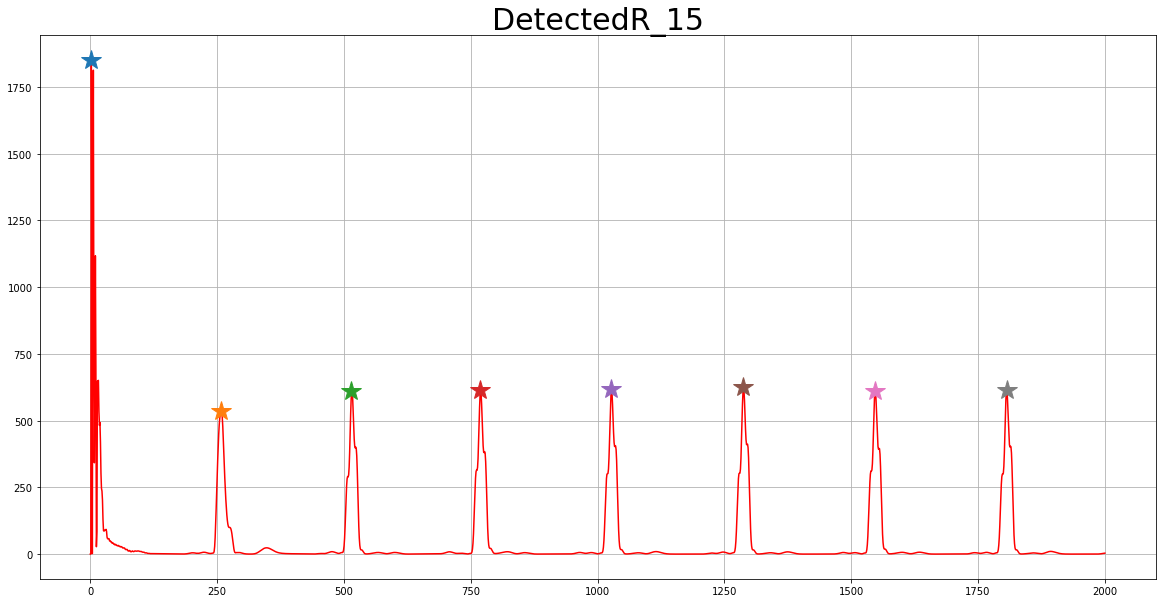

In [297]:
smooth_filtered_15 =smooth_filtered_15[0:2000]
RR15_figure, RR15_ax = plt.subplots(figsize=(20, 10))
RR15_ax.plot(time,smooth_filtered_15, color='red')
RR15_ax.set_title('DetectedR_15', fontsize= 30)
RR15_ax.grid()
for i, v in enumerate(smooth_filtered_15):
        if v in R15_peaks:
            plt.plot(time[i]-0.4, v+0.01,  marker='*', markersize=20)

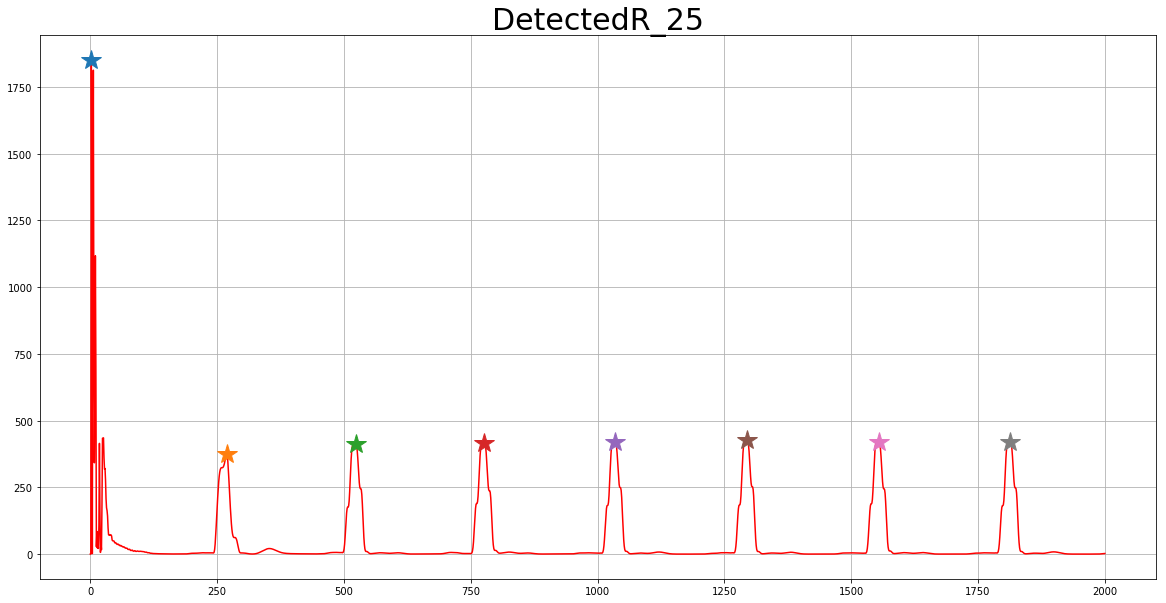

In [298]:
smooth_filtered_25 = smooth_filtered_25[0:2000]
RR25_figure, RR25_ax = plt.subplots(figsize=(20, 10))
RR25_ax.plot(time,smooth_filtered_25, color='red')
RR25_ax.set_title('DetectedR_25', fontsize= 30)
RR25_ax.grid()
for i, v in enumerate(smooth_filtered_25):
        if v in R25_peaks:
            plt.plot(time[i]-0.4, v+0.01,  marker='*', markersize=20)

## What can you conclude about the optimal setting of N?

### Increasing the window size decreased the abrupt changes in the signals. By comparing the output signal of window size 5, 15 and 25, using 25 for a window size gave the smoothest signals and the peak became more aligned with the supposed position of the R wave.

## ECG Signals With Different WIndow Sizes, Without Noise Filtering

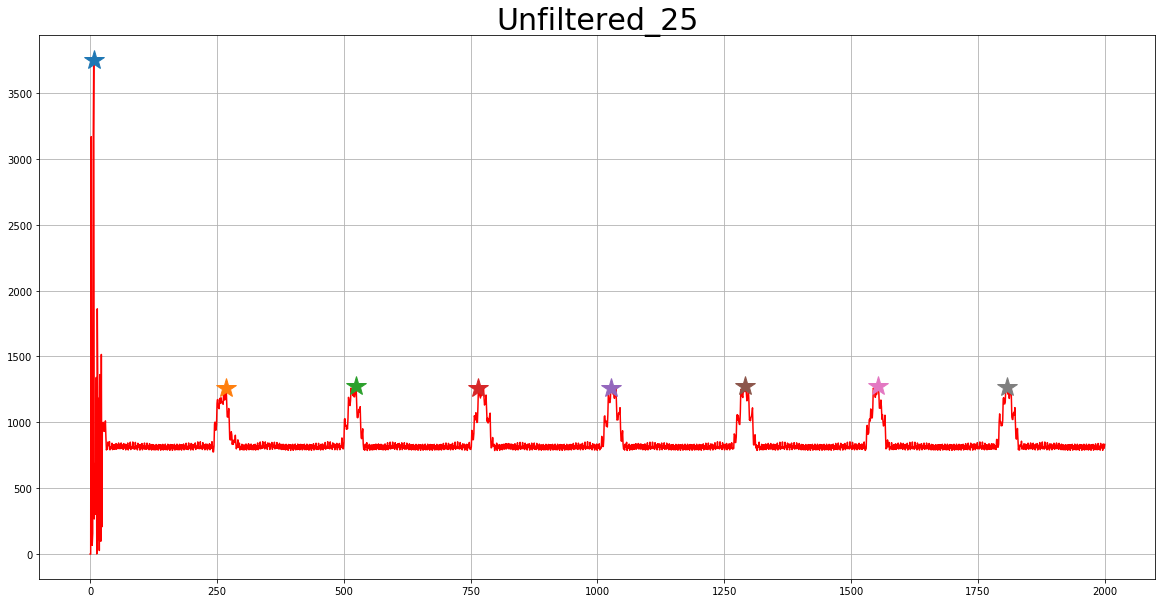

In [299]:
noisy_N25 = signals[0:2000]
R_peaks_with_noise, noisy_samples_N25,_ = electrocardiogram(signals, 25)
noisy_samples_N25= noisy_samples_N25[0:2000]

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(time,noisy_samples_N25, color='red')
ax.set_title('Unfiltered_25', fontsize= 30)
ax.grid()
for i, v in enumerate(noisy_samples_N25):
        if v in R_peaks_with_noise:
            plt.plot(time[i]-0.4, v+0.01,  marker='*', markersize=20)

## RR Intervals 

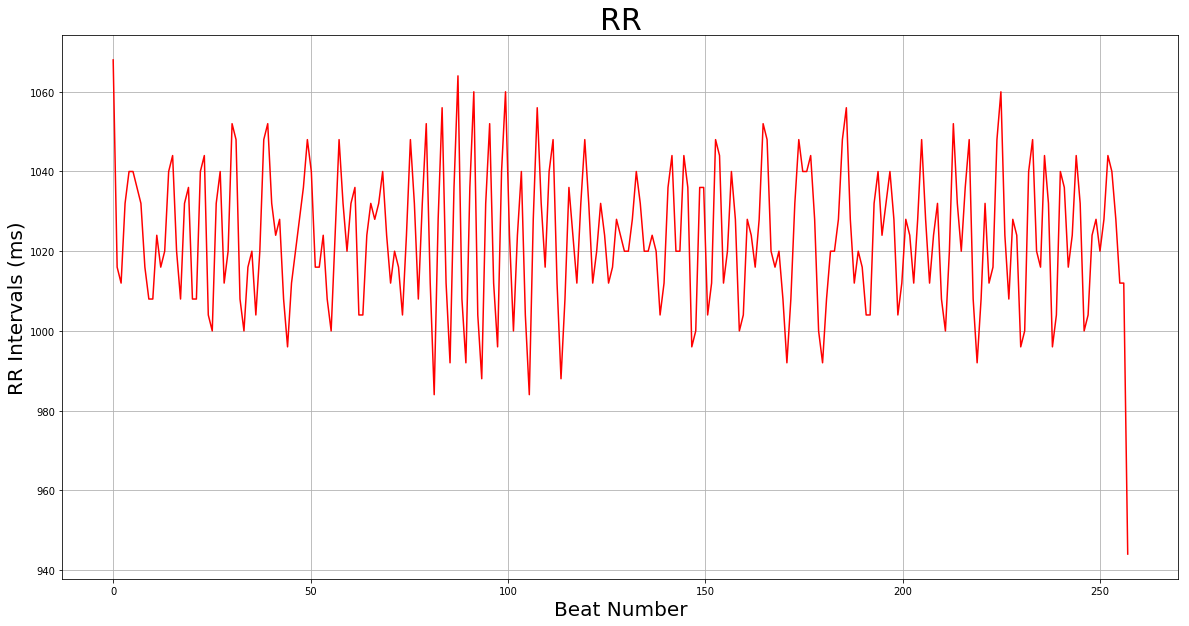

In [345]:
period = round((1/sample_rate) * (1000))
timestamps = []
RR_intervals= []


for index in R25_indices[0]:
    timestamp = index*period
    timestamps.append(timestamp)
    
for timestamp_index in range(0, len(timestamps)-1):
    RR_interval = timestamps[timestamp_index+1] - timestamps[timestamp_index]
    RR_intervals.append(RR_interval)

beat_number = np.linspace(0, 257, 257)

RR_interval_figure, RR_interval_ax = plt.subplots(figsize=(20, 10))
RR_interval_ax.plot(beat_number,RR_intervals, color='red')
RR_interval_ax.set_title('RR', fontsize= 30)
RR_interval_ax.set_ylabel('RR Intervals (ms)', fontsize= 20)
RR_interval_ax.set_xlabel('Beat Number', fontsize= 20)


RR_interval_ax.grid()
    